In [1]:
%matplotlib inline

import glob
import os
import random
import json
import sys
import importlib

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metricBundles as metricBundles
from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from rubin_sim.utils import getPackageDir
#from rubin_sim.maf import KN_lc, KNePopMetric, generateKNPopSlicer, get_filename
import healpy as hp

In [10]:
if "LFBOT" in sys.modules:
    del sys.modules["LFBOT"]

import LFBOT
importlib.reload(LFBOT)

from LFBOT import LFBOT_lc, LFBOTPopMetric, LFBOTPopMetricDetect, generateLFBOTPopSlicer
print(LFBOT.__file__)

/home/andra104/Stuff/AllTransient_MetricDetection/LFBOT.py


Total LFBOT events simulated: 6269
First few peak times (days): [ 932.84917297  326.85084323  288.27403149 1556.87930339 3454.27793749]
First few file indices: [23 85 66 36  1]


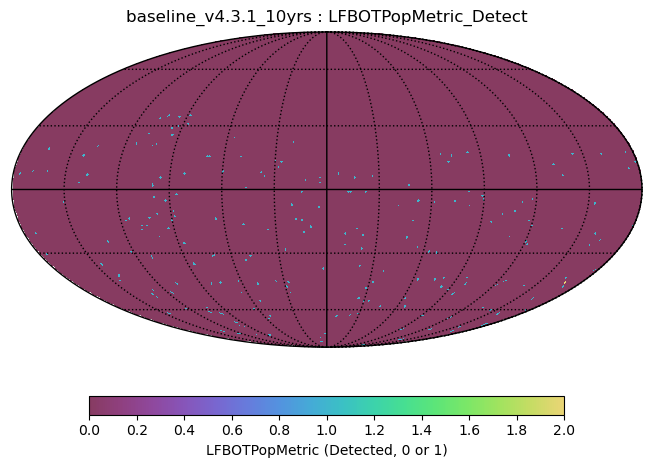

In [11]:


# LFBOT detection parameters
dmin = 10   # Minimum distance in Mpc
dmax = 600  # Adjusted max distance for LFBOTs


cadence_nickname = 'baseline_v4.3.1_10yrs'  # Used in output filenames

# Output file for LFBOT efficiency results
outfile = f"AllTransient_MetricDetection/efficiency_{cadence_nickname}_LFBOT.csv"

# Start an output file
with open(outfile, "w") as out:
    out.write("dist_min_Mpc, dist_max_Mpc, metric, found, total, efficiency\n")

# Generate the LFBOT population slicer
slicer = generateLFBOTPopSlicer(seed=42, n_files=100, d_min=dmin, d_max=dmax)

# Load Rubin cadence database
runName = 'baseline_v4.3.1_10yrs'
opsdb = db.OpsimDatabase(f'../AllTransient_MetricDetection/{runName}.db')

outDir = "AllTransient_MetricDetection/Metric_temp"
resultsDb = db.ResultsDb(outDir=outDir)

print(f"Total LFBOT events simulated: {len(slicer.slicePoints['peak_time'])}")
print(f"First few peak times (days): {slicer.slicePoints['peak_time'][:5]}")
print(f"First few file indices: {slicer.slicePoints['file_indx'][:5]}")

# Use the updated LFBOTPopMetricDetect
metric_detect = LFBOTPopMetricDetect(outputLc=False)

# Configure metric bundle
sql = ''

# Define plotDict
plotDict_detect = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0, 'title': f'{runName} : LFBOTPopMetric_Detect'}

plotFuncs = [plots.HealpixSkyMap()]
summaryMetrics = [metrics.MeanMetric(maskVal=0)]

# Define metric bundles
bundles = [
    metricBundles.MetricBundle(metric_detect, slicer, sql, runName=runName,
                               plotDict=plotDict_detect, plotFuncs=plotFuncs, summaryMetrics=summaryMetrics,
                               fileRoot=f"{runName}_LFBOTPopMetric_Detect"),
]

# Convert list to dictionary for MetricBundleGroup
bd = metricBundles.makeBundlesDictFromList(bundles)

# Define `bgroup` before calling `bgroup.runAll()`
bgroup = metricBundles.MetricBundleGroup(bd, opsdb, outDir=outDir, resultsDb=resultsDb)

bgroup.runAll()
bgroup.plotAll(closefigs=False)

# Collect results
with open(outfile, "a") as out:
    for key in bd:
        if "USER" in key:
            continue
        found = np.size(np.where(bd[key].metricValues == 1)[0])
        out.write(f"{dmin}, {dmax}, {key}, {found}, {len(slicer.slicePoints['peak_time'])}, {found/len(slicer.slicePoints['peak_time'])}\n")


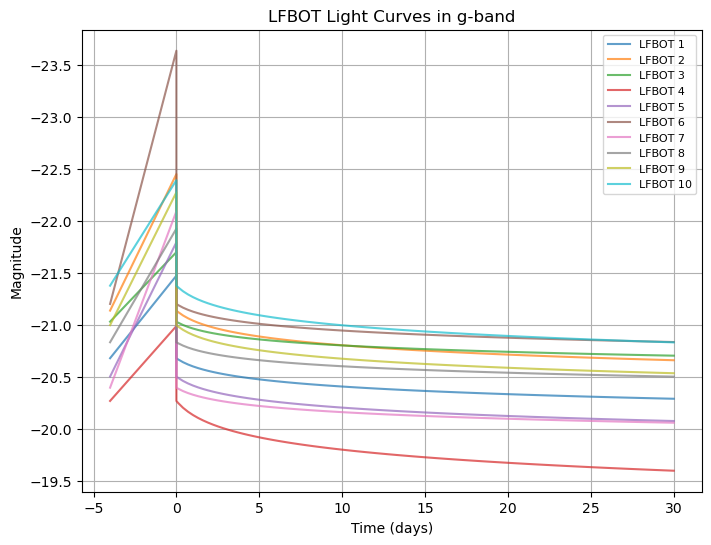

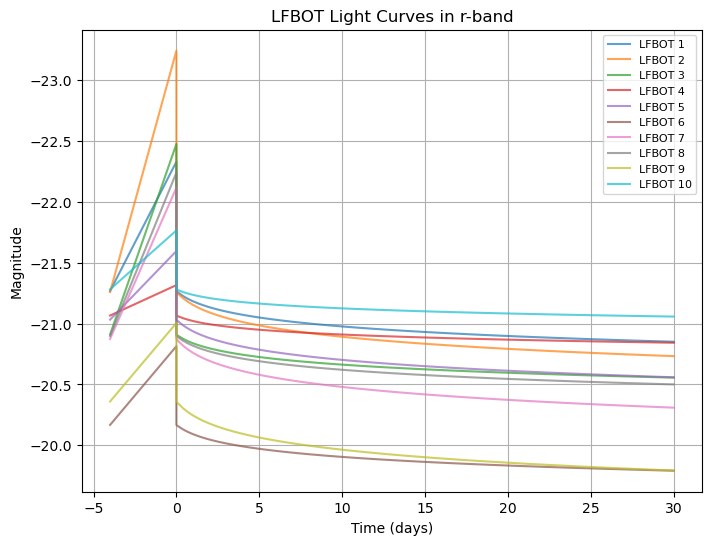

In [12]:
lfbot = LFBOT_lc(num_samples=100)
lfbot.plot_light_curves(num_to_plot=10)
